# Austin Bike Share Daily Rental Predictions
The goal of this project is to take data provided by Austin Bike Share from 2013 to 2017 and predict what the daily rentals will be at a given bike share station. The predictions will be tested on the provided data in 2017 and the training/validation will be done on the data for 2013-2016. 


## Preprocessing Data
data here will be preprocessed to get a good bird`s eye view of the trends and patterns. 

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn as sk # SkLearn ML library
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
import seaborn as sns
import requests
from datetime import datetime

# Input data files are available in the "austin-bike" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory


from subprocess import check_output
print(check_output(["ls", "austin-bike"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

austin_bikeshare_stations.csv
austin_bikeshare_trips.csv
austin_weather.csv



In [5]:
# load data in 

trips = pd.read_csv('austin-bike/austin_bikeshare_trips.csv')
stations = pd.read_csv('austin-bike/austin_bikeshare_stations.csv')


In [6]:
weather = pd.read_csv('austin-bike/austin_weather.csv')


In [7]:
trips.head()

,bikeid,checkout_time,duration_minutes,end_station_id,end_station_name,month,start_station_id,start_station_name,start_time,subscriber_type,trip_id,year
0,8.0,19:12:00,41,2565.0,Trinity & 6th Street,3.0,2536.0,Waller & 6th St.,2015-03-19 19:12:00,Walk Up,9900082882,2015.0
1,141.0,2:06:04,6,2570.0,South Congress & Academy,10.0,2494.0,2nd & Congress,2016-10-30 02:06:04,Local365,12617682,2016.0
2,578.0,16:28:27,13,2498.0,Convention Center / 4th St. @ MetroRail,3.0,2538.0,Bullock Museum @ Congress & MLK,2016-03-11 16:28:27,Local365,9075366,2016.0
3,555.0,15:12:00,80,2712.0,Toomey Rd @ South Lamar,11.0,2497.0,Capitol Station / Congress & 11th,2014-11-23 15:12:00,24-Hour Kiosk (Austin B-cycle),9900319298,2014.0
4,86.0,15:39:13,25,3377.0,MoPac Pedestrian Bridge @ Veterans Drive,4.0,2707.0,Rainey St @ Cummings,2017-04-16 15:39:13,Walk Up,14468597,2017.0


In [8]:
stations.head()

,latitude,location,longitude,name,station_id,status
0,30.27041,(30.27041 -97.75046),-97.75046,West & 6th St.,2537,active
1,30.26452,(30.26452 -97.7712),-97.77120,Barton Springs Pool,2572,active
2,30.27595,(30.27595 -97.74739),-97.74739,ACC - Rio Grande & 12th,2545,closed
3,30.28480,(30.2848 -97.72756),-97.72756,Red River & LBJ Library,1004,closed
4,30.26694,(30.26694 -97.74939),-97.74939,Nueces @ 3rd,1008,moved


In [9]:
weather.head()

,Date,TempHighF,TempAvgF,TempLowF,DewPointHighF,DewPointAvgF,DewPointLowF,HumidityHighPercent,HumidityAvgPercent,HumidityLowPercent,...,SeaLevelPressureAvgInches,SeaLevelPressureLowInches,VisibilityHighMiles,VisibilityAvgMiles,VisibilityLowMiles,WindHighMPH,WindAvgMPH,WindGustMPH,PrecipitationSumInches,Events
0,2013-12-21,74,60,45,67,49,43,93,75,57,...,29.68,29.59,10,7,2,20,4,31,0.46,"Rain , Thunderstorm"
1,2013-12-22,56,48,39,43,36,28,93,68,43,...,30.13,29.87,10,10,5,16,6,25,0,
2,2013-12-23,58,45,32,31,27,23,76,52,27,...,30.49,30.41,10,10,10,8,3,12,0,
3,2013-12-24,61,46,31,36,28,21,89,56,22,...,30.45,30.3,10,10,7,12,4,20,0,
4,2013-12-25,58,50,41,44,40,36,86,71,56,...,30.33,30.27,10,10,7,10,2,16,T,


Do a categorial encoding of weather events

In [10]:
Rain = []
Thunderstorm = []
Fog = []
Snow = []
for row in weather['Events']:
    if 'Rain' in row:
        Rain.append(1)
    else:
        Rain.append(0)
        
    if 'Thunderstorm' in row:
        Thunderstorm.append(1)
    else:
        Thunderstorm.append(0)
        
    if 'Fog' in row:
        Fog.append(1)
    else:
        Fog.append(0)
        
    if 'Snow' in row:
        Snow.append(1)
    else:
        Snow.append(0)
weather['PrecipitationSumInches'] = np.where(weather['PrecipitationSumInches'] == 'T', 0.001, weather['PrecipitationSumInches'])
weather['Rain'] = Rain
weather['Thunderstorm'] = Thunderstorm
weather['Fog'] = Fog
weather['Snow'] = Snow

In [11]:
weather.summary()

AttributeError: 'DataFrame' object has no attribute 'summary'

## Station Analysis
this section will look at trends for the stations

In [12]:
# calculate the lifetime rentals of each station
start_station_usage = trips.start_station_name.value_counts()
top5Stations = start_station_usage.index[:5]
print(top5Stations)

# count the number of stations that have been used
print("total stations that have had bikes rented from are: ", len(start_station_usage))

# count the number of lifetime rentals
print("total number of rentals in the dataset are: ", len(trips))

Index(['Riverside @ S. Lamar', 'City Hall / Lavaca & 2nd', '5th & Bowie',
       '2nd & Congress', '4th & Congress'],
      dtype='object')
total stations that have had bikes rented from are:  90
total number of rentals in the dataset are:  649231


## Day of Week Analysis

In [13]:
# calculate bike rentals by day of the week
import calendar
trips['dayofweek'] = pd.to_datetime(trips.start_time).dt.dayofweek

dayofweek_counts = trips.dayofweek.value_counts()

5    140846
6    114337
4    102187
0     77707
3     75704
2     70007
1     68443
Name: dayofweek, dtype: int64


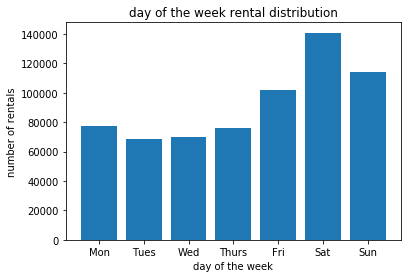

In [14]:
# plot the day of the week rental distribution
import matplotlib.pyplot as plt
print(dayofweek_counts)
dayofweek_counts = dayofweek_counts.sort_index()
daysofweek = ('Mon','Tues','Wed','Thurs','Fri','Sat','Sun')
y_pos = np.arange(len(daysofweek))
plt.bar(y_pos,dayofweek_counts)
plt.xticks(y_pos, daysofweek)
plt.title('day of the week rental distribution')
plt.ylabel('number of rentals')
plt.xlabel('day of the week')
plt.show()


This shows that Friday, Saturday, Sunday had the highest usage. This seems to make sense as I assume the primary use would be for recreational transportation. If people were using these bikes ore than 5 times a week, it may become more cost efficient just to purchase a bike to own. But if people are using them once or twice a week to get to areas where automobile parking is scarce, such as shopping districts, it may be easier to use the bike share. 

In [12]:
top5StationTrips = trips[trips['start_station_name'].isin(top5Stations)]
# print(top5StationTrips)
print(len(top5StationTrips))

135483


When we trim our dataset down to only rentals from the 5 most popular bike share rental stations, we trim our dataset by almost a fifth. To put into perspective, 5 out of 71 (or roughly 7%) unique stations contribute to over 20% of the bike share demand! 

0    17155
1    15266
2    15552
3    16327
4    20776
5    27004
6    23403
Name: dayofweek, dtype: int64


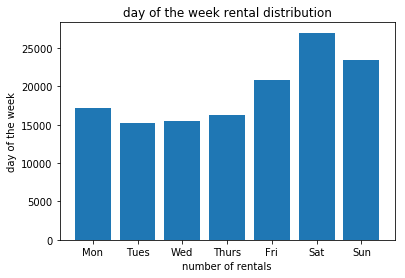

In [13]:
dayofweek_top5counts = top5StationTrips.dayofweek.value_counts()
dayofweek_top5counts = dayofweek_top5counts.sort_index()

print(dayofweek_top5counts)
daysofweek = ('Mon','Tues','Wed','Thurs','Fri','Sat','Sun')

y_pos = np.arange(len(daysofweek))
plt.bar(y_pos,dayofweek_top5counts)
plt.xticks(y_pos, daysofweek)
plt.title('day of the week rental distribution')
plt.xlabel('number of rentals')
plt.ylabel('day of the week')
plt.show()

The same day of week distributions of the top 5 stations show a very similar distribution as the total. Cool. 

## Monthly bike rental analysis


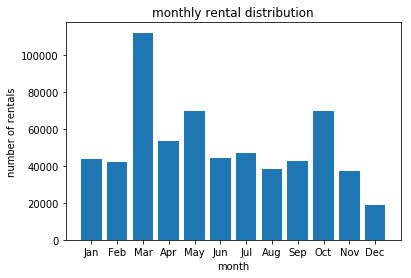

In [15]:
# get monthly totals
monthlyCounts = trips.month.value_counts().sort_index()
monthNames = ('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec')

y_pos = np.arange(len(monthNames))
plt.bar(y_pos,monthlyCounts)
plt.xticks(y_pos, monthNames)
plt.title('monthly rental distribution')
plt.ylabel('number of rentals')
plt.xlabel('month')
plt.show()

Wow, there is a big jump in rental usage in March. Followed by May and October. Let's split up the data for the month of March and see what we can find. 

the standard deviation of data collected in March is : 1867.0288562312046


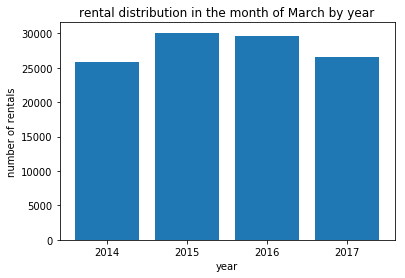

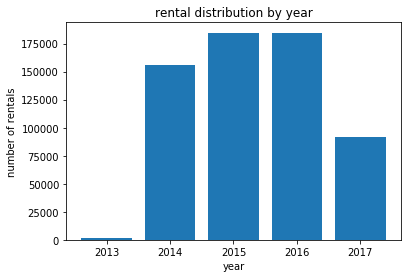

In [15]:
# we want to see here what is so special about March. First we will look at the distribution of March by year vs. the
# distribution of all the data by year. 

# this creates a subset of data that only contains rentals made in the month of March
MarchTrips = trips[trips['month'] == 3.0]
# print(MarchTrips)

# count the total trips made in March per year
MarchCounts = MarchTrips.year.value_counts().sort_index()
# calculate the standard deviation of MarchTrips
MarchCounts.stdev = np.std(MarchCounts)
print("the standard deviation of data collected in March is :",MarchCounts.stdev)
# print(MarchCounts)
yearNames = ('2014','2015','2016','2017')

# create a bar plot of the data to represent the yearly distribution. 
y_pos = np.arange(len(yearNames))
plt.bar(y_pos,MarchCounts)
plt.xticks(y_pos, yearNames)
plt.title('rental distribution in the month of March by year')
plt.xlabel('year')
plt.ylabel('number of rentals')
plt.show()

# count the total trips made per year
yearlyCounts = trips.year.value_counts().sort_index()
# print(yearlyCounts)
yearNames = ('2013','2014','2015','2016','2017')

# create a bar plot of the data to represent the yearly distribution. 
y_pos = np.arange(len(yearNames))
plt.bar(y_pos, yearlyCounts)
plt.xticks(y_pos, yearNames)
plt.title('rental distribution by year')
plt.xlabel('year')
plt.ylabel('number of rentals')
plt.show()

We see here that there is very little change in usage by year for the month of March. When we compare to the entire dataset, we see a similar distribution for the years 2014-2016 but 2017 is much lower. The dataset only includes data through July 2017, so we should expect rentals for the year 2017 to be about half if monthly usage is consistent. But the for the month of March, we have a full dataset so its rental numbers are consistent with the years previous to it. In short, just looking at yearly data doesn't give us any key insights as to why March was such a high usage month. But it does tell us that there wasn't a promotion that ran for a March of a particular year that offset the average values. All the March reports were fairly similar, with a standard deviation of 1867, or less than 10%. Perhaps we can look at daily data instead to see if the peak is localized to a few days or if the whole month had consistently high usage. 

### Daily usage for the month of March - with a little preprocessing first
while the month and year are given their own column in the dataframe, the day of the month is not. We will have to parse that from start_time. I will take some time to add the day of the month and time as their own columns to trips. 

In [16]:
t = pd.to_datetime(trips.start_time)
t.head()
trips['day'] = t.map(lambda x: x.day)
trips.head()

,bikeid,checkout_time,duration_minutes,end_station_id,end_station_name,month,start_station_id,start_station_name,start_time,subscriber_type,trip_id,year,dayofweek,day
0,8.0,19:12:00,41,2565.0,Trinity & 6th Street,3.0,2536.0,Waller & 6th St.,2015-03-19 19:12:00,Walk Up,9900082882,2015.0,3,19
1,141.0,2:06:04,6,2570.0,South Congress & Academy,10.0,2494.0,2nd & Congress,2016-10-30 02:06:04,Local365,12617682,2016.0,6,30
2,578.0,16:28:27,13,2498.0,Convention Center / 4th St. @ MetroRail,3.0,2538.0,Bullock Museum @ Congress & MLK,2016-03-11 16:28:27,Local365,9075366,2016.0,4,11
3,555.0,15:12:00,80,2712.0,Toomey Rd @ South Lamar,11.0,2497.0,Capitol Station / Congress & 11th,2014-11-23 15:12:00,24-Hour Kiosk (Austin B-cycle),9900319298,2014.0,6,23
4,86.0,15:39:13,25,3377.0,MoPac Pedestrian Bridge @ Veterans Drive,4.0,2707.0,Rainey St @ Cummings,2017-04-16 15:39:13,Walk Up,14468597,2017.0,6,16


In [17]:
# we will add column `time` to represent the hour that the rental took place. We will round down for simplicity. 
trips['time'] = t.map(lambda x: x.hour)
trips['time'].head()

0    19
1     2
2    16
3    15
4    15
Name: time, dtype: int64

Ok, now that we have that bit of preprocessing done, we can look at the daily stats for the month of March! We will aggregate the yearly data again as we saw that the numbers did not vary much by year. `

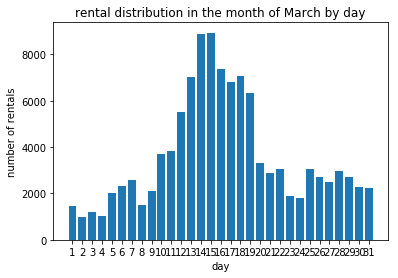

In [18]:
# we need to recreate MayTrips since trips was updated
MayTrips = trips[trips['month'] == 3.0]
# count the total trips made in March per year
MayDayCounts = MayTrips.day.value_counts().sort_index()
# print(MayCounts)
dayNames = tuple(range(1,32))

# create a bar plot of the data to represent the yearly distribution. 
y_pos = np.arange(len(dayNames))
plt.bar(y_pos,MayDayCounts)
plt.xticks(y_pos, dayNames)
plt.title('rental distribution in the month of March by day')
plt.xlabel('day')
plt.ylabel('number of rentals')
plt.show()

So looking at daily stats for March, it does seem that there is higher usage between the 12-19th. That is a one week span. A quick Google search of "Austin Texas March 12-19" pulls up results for SXSW. This is a yearly event that spans over a week and draws lots of visitors from all over the US and world. According to http://www.512tech.com/technology/sxsw-says-had-421-900-2017-events-continues-unifying-conferences/LeLK0RwIbaDXpBgF4UpIyH/, in 2017 there were over 70k participants at the event. This explains the mystery of why March had such high rental numbers. People visiting Austin for SXSW were using Austin Bike Share to get around town! 

## Formatting trips by day
Next we will format trips data by day as the index and each column representing a bike share rental station. Each cell will contain an int for the number of rentals for the corresponding day and station. 

In [19]:
# add a date column that contains 
import dateutil.parser
trips['date'] = trips['start_time'].map(lambda x: dateutil.parser.parse(x).date())
trips['date'] = trips['date'].map(lambda x: x.strftime('%Y-%m-%d'))
trips['date'].head()

0    2015-03-19
1    2016-10-30
2    2016-03-11
3    2014-11-23
4    2017-04-16
Name: date, dtype: object

In [157]:
firstDay = min(trips['date'])
lastDay = max(trips['date'])
days = pd.date_range(firstDay,lastDay).map(lambda x: x.date())
daylist = days.tolist()

In [2]:
tripCount = trips.date.value_counts()
tripCount.sort_index(inplace=True)
tripCount.head()
plt.plot(tripCount)
plt.title('line plot of daily bike rental counts over lifetime of bike share rental')
plt.ylabel('daily rental counts')
plt.xlabel('time (days)')
plt.show()

NameError: name 'trips' is not defined

In [22]:
# create a new variable tripInfo that has daily stats such as weather 
# and total trips at each station
tripInfo = pd.DataFrame(index=days)
tripInfo.head()


""
2013-12-21
2013-12-22
2013-12-23
2013-12-24
2013-12-25


In [23]:
# add weather related data
tripInfo['TempAvgF'] = (weather['TempAvgF'].values.tolist())
tripInfo['avgHumid'] = weather['HumidityAvgPercent'].values.tolist()
tripInfo['avgWindSpd'] = weather['WindAvgMPH'].values.tolist()
tripInfo['Rain'] = Rain
tripInfo['Thunderstorm'] = Thunderstorm
tripInfo['Fog'] = Fog
tripInfo['Snow'] = Snow
tripInfo['Percip'] = weather['PrecipitationSumInches'].values.tolist()
tripInfo.head()

,TempAvgF,avgHumid,avgWindSpd,Rain,Thunderstorm,Fog,Snow,Percip
2013-12-21,60,75,4,1,1,0,0,0.46
2013-12-22,48,68,6,0,0,0,0,0
2013-12-23,45,52,3,0,0,0,0,0
2013-12-24,46,56,4,0,0,0,0,0
2013-12-25,50,71,2,0,0,0,0,0.001


In [202]:
# add trip counts by station
dayliststr = days.map(lambda x: x.strftime('%Y-%m-%d')).tolist()
for station in top5Stations:
    tempTrips = trips[trips['start_station_name']==station]
    tempCount = []
    for day in dayliststr:
        tempCount.append(len(tempTrips[tempTrips['date']==day]))
    tripCounts[station] = tempCount
#     if station == 'Riverside @ S. Lamar':
#         station1 = tempCount
#     elif station == 'City Hall / Lavaca & 2nd':
#         station2 = tempCount
#     elif station == '5th & Bowie':
#         station3 = tempCount
#     elif station == '2nd & Congress':
#         station4 = tempCount
#     elif station == '4th & Congress':
#         station5 = tempCount

In [201]:
top5Stations[0]

'Riverside @ S. Lamar'

In [154]:
tripCounts = pd.DataFrame(index=days)

tripCounts['station1']=station1
tripCounts['station2']=station2
tripCounts['station3']=station3
tripCounts['station4']=station4
tripCounts['station5']=station5


In [204]:
# each column in trip counts represents a bike share station with a daily total of rentals. This will be our Y label. 
# the regressions will be run for each station independently. 
tripCounts.head()

,station1,station2,station3,station4,station5,Riverside @ S. Lamar,City Hall / Lavaca & 2nd,5th & Bowie,2nd & Congress,4th & Congress
2013-12-21,0,15,11,9,9,0,15,11,9,9
2013-12-22,0,11,23,13,9,0,11,23,13,9
2013-12-23,0,12,9,6,6,0,12,9,6,6
2013-12-24,0,6,11,5,7,0,6,11,5,7
2013-12-25,0,15,15,9,15,0,15,15,9,15


In [158]:
a = pd.Series(daylist)
b = pd.to_datetime(a).dt.dayofweek
year = [date.year for date in daylist]
month = [date.month for date in daylist]
tripInfo['dayOfWeek'] = b.tolist()
tripInfo['year'] = year
tripInfo['month'] = month


In [159]:
# tripInfo is our X_labels. It contains weather and date data
tripInfo.head()

,TempAvgF,avgHumid,avgWindSpd,Rain,Thunderstorm,Fog,Snow,Percip,dayOfWeek,year,month
2013-12-21,60,75,4,1,1,0,0,0.46,5,2013,12
2013-12-22,48,68,6,0,0,0,0,0,6,2013,12
2013-12-23,45,52,3,0,0,0,0,0,0,2013,12
2013-12-24,46,56,4,0,0,0,0,0,1,2013,12
2013-12-25,50,71,2,0,0,0,0,0.001,2,2013,12


In [160]:
tripInfo.isnull().sum()

TempAvgF        0
avgHumid        0
avgWindSpd      0
Rain            0
Thunderstorm    0
Fog             0
Snow            0
Percip          0
dayOfWeek       0
year            0
month           0
dtype: int64

## training time!
this section will focus on training. yay!


In [32]:
# import our machine learning libraries
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import model_selection, preprocessing

In [35]:
# this function will be how we measure error
# it is the root mean squared logarithmic error
def rmsle(y, y_):
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [304]:
# set up test and train datasets
X_train = tripInfo[tripInfo['year'] < 2017]
X_test = tripInfo[tripInfo['year'] == 2017]

# set up thwe y_label. This will be different for each station
f = '%Y-%m-%d'
endDate = datetime.strptime('2017-01-01', f).date()
y1_train = tripCounts.station1[tripCounts.index < endDate].reset_index(drop=True)
y2_train = tripCounts.station2[tripCounts.index < endDate].reset_index(drop=True)
y3_train = tripCounts.station3[tripCounts.index < endDate].reset_index(drop=True)
y4_train = tripCounts.station4[tripCounts.index < endDate].reset_index(drop=True)
y5_train = tripCounts.station5[tripCounts.index < endDate].reset_index(drop=True)

y1_test = tripCounts.station1[tripCounts.index >= endDate].reset_index(drop=True)
y2_test = tripCounts.station2[tripCounts.index >= endDate].reset_index(drop=True)
y3_test = tripCounts.station3[tripCounts.index >= endDate].reset_index(drop=True)
y4_test = tripCounts.station4[tripCounts.index >= endDate].reset_index(drop=True)
y5_test = tripCounts.station5[tripCounts.index >= endDate].reset_index(drop=True)

In [250]:
tripInfo.reset_index(drop=True,inplace=True)
tripInfo.head()


,TempAvgF,avgHumid,avgWindSpd,Rain,Thunderstorm,Fog,Snow,Percip,dayOfWeek,year,month
0,60,75,4,1,1,0,0,0.46,5,2013,12
1,48,68,6,0,0,0,0,0,6,2013,12
2,45,52,3,0,0,0,0,0,0,2013,12
3,46,56,4,0,0,0,0,0,1,2013,12
4,50,71,2,0,0,0,0,0.001,2,2013,12


In [291]:
a = tripInfo.TempAvgF


pandas.core.series.Series

In [251]:
pd.to_numeric(tripInfo.avgHumid)

0       75
1       68
2       52
3       56
4       71
5       63
6       65
7       64
8       76
9       60
10      54
11      68
12      55
13      49
14      68
15      59
16      38
17      43
18      75
19      80
20      81
21      53
22      68
23      51
24      41
25      35
26      38
27      31
28      45
29      39
        ..
1289    63
1290    62
1291    60
1292    58
1293    60
1294    61
1295    59
1296    56
1297    57
1298    58
1299    59
1300    59
1301    58
1302    65
1303    67
1304    63
1305    61
1306    60
1307    56
1308    56
1309    58
1310    58
1311    60
1312    61
1313    58
1314    54
1315    54
1316    51
1317    48
1318    43
Name: avgHumid, Length: 1319, dtype: int64

In [232]:
tripInfo.avgHumid[tripInfo.avgHumid == '-'] = 0

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [306]:
clf = LinearRegression(normalize= True)
clf.fit(X_train, y2_train)
print("The accuracy of linear regression is: ", clf.score(X_test, y2_test), "\nThe RMSLE is: ", rmsle(y2_test, clf.predict(X_test)))

ValueError: setting an array element with a sequence.

In [283]:
def scoring(clf):
    scores = cross_val_score(clf, X_train, y2_train, cv=15, n_jobs=1, scoring = 'neg_median_absolute_error')
    print (np.median(scores) * -1)